In [128]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from BabyMAKROModel import BabyMAKROModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

In [129]:
model = BabyMAKROModelClass(name='baseline') # create an instance of the model

In [130]:
par = model.par
ss = model.ss
sol = model.sol

# Find steady state

In [131]:
model.find_ss(0.50,do_print=True)

ss.S = 7.44
ss.L = 56.28
ss.delta_L = 0.07
ss.v = 16.52
ss.m_v = 0.23
ss.r_K = 0.14
ss.r_ell = 2.71
ss.ell = 55.87
ss.w = 2.68
ss.G = 100.00
ss.tau = 0.67
solving for household behavior: result.converged = True
ss.C = 50.97
ss.B = 153.85
ss.K = 557.43
ss.I = 55.74
ss.Y = 229.56
ss.X = nan
ss.M = nan
par.phi = 0.988


**Household behavior:**

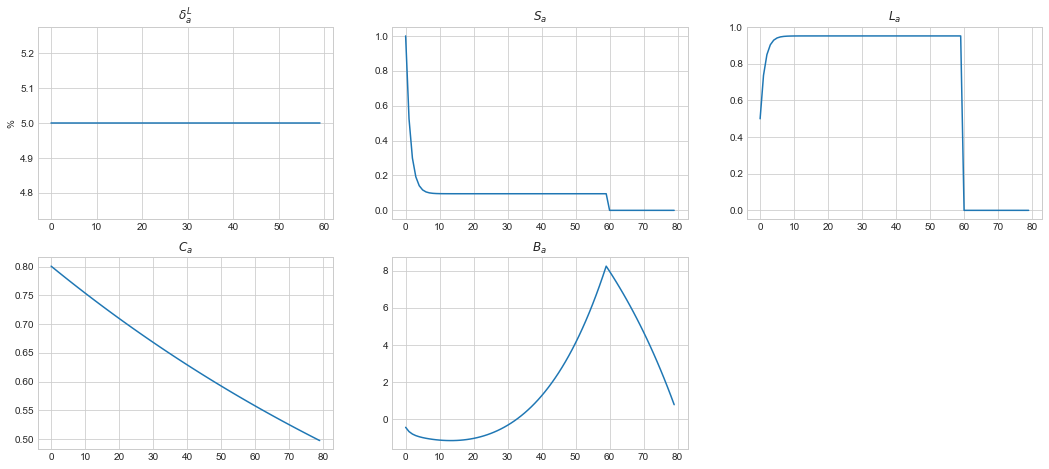

In [132]:
fig = plt.figure(figsize=(3*6,3*6/1.5))

ax = fig.add_subplot(3,3,1)
ax.plot(model.par.delta_L_a*100)
ax.set_ylabel('%')
ax.set_title('$\delta^L_a$')

ax = fig.add_subplot(3,3,2)
ax.plot(model.ss.S_a)
ax.set_title('$S_a$')

ax = fig.add_subplot(3,3,3)
ax.plot(model.ss.L_a)
ax.set_title('$L_a$')

ax = fig.add_subplot(3,3,4)
ax.plot(model.ss.C_a)
ax.set_ylabel('')
ax.set_title('$C_a$')

ax = fig.add_subplot(3,3,5)
ax.plot(model.ss.B_a)
ax.set_ylabel('')
ax.set_title('$B_a$');

# Speed and error tests

In [133]:
model.set_exo_ss()
model.set_unknowns_ss()

**Python evaluation:**

In [134]:
%time model.evaluate_blocks(py=True)

CPU times: user 4.17 s, sys: 120 ms, total: 4.29 s
Wall time: 5.91 s


**Check errors:**

In [135]:
errors = model.get_errors(do_print=True)

bargaining_cond     : abs. max = 0.00e+00
Bq_match            : abs. max = 9.01e-13
FOC_capital_agency  : abs. max = 0.00e+00
FOC_K_ell           : abs. max = 7.11e-15
mkt_clearing        : abs. max = 0.00e+00


**First numba evaluation:**

In [136]:
%time model.evaluate_blocks()

CPU times: user 44.8 s, sys: 1.36 s, total: 46.2 s
Wall time: 56.3 s


**Time:**

In [137]:
%timeit model.evaluate_blocks()
%timeit model.get_errors()

11.3 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
66.8 µs ± 9.28 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [138]:
%timeit model.evaluate_blocks(py=True)

691 ms ± 10.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Find an impulse-response

**Calculate Jacobian:**

In [139]:
model.calc_jac(do_print=True)

Jacobian calculated in 43.6 secs secs


Only needs to be calculated once.

**Set exogenous variables:**

In [140]:
model.set_exo_ss()

Here we shock export demand:

In [141]:
Tshock = 50
shock = 0.01*ss.chi
persistence = 0.8**np.arange(Tshock)
sol.chi[:Tshock] = ss.chi + shock*persistence

Check errors when guessing at steady state -> excess demand

In [142]:
model.set_unknowns_ss()
model.evaluate_blocks()
errors = model.get_errors(do_print=True)

bargaining_cond     : abs. max = 0.00e+00
Bq_match            : abs. max = 1.26e-12
FOC_capital_agency  : abs. max = 0.00e+00
FOC_K_ell           : abs. max = 8.88e-15
mkt_clearing        : abs. max = 5.15e-01


**Find IRF:**

In [143]:
model.find_IRF()

initial:
   max. abs. error = 5.15e-01
    0.00e+00 in bargaining_cond
    1.26e-12 in Bq_match
    0.00e+00 in FOC_capital_agency
    8.88e-15 in FOC_K_ell
    5.15e-01 in mkt_clearing

it = 0
 solve: t1-t0 = 0.7 secs
   max. abs. error = 5.15e-01
    5.04e-06 in bargaining_cond
    4.78e-03 in Bq_match
    1.15e-05 in FOC_capital_agency
    7.62e-04 in FOC_K_ell
    8.67e-03 in mkt_clearing
 evaluate: t1-t0 = 0.1 secs
 update_jac: t1-t0 = 0.1 secs

it = 1
 solve: t1-t0 = 1.3 secs
   max. abs. error = 8.67e-03
    1.24e-07 in bargaining_cond
    6.08e-05 in Bq_match
    2.16e-07 in FOC_capital_agency
    3.15e-05 in FOC_K_ell
    3.12e-04 in mkt_clearing
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 2
 solve: t1-t0 = 0.7 secs
   max. abs. error = 3.12e-04
    3.20e-09 in bargaining_cond
    1.35e-06 in Bq_match
    5.30e-09 in FOC_capital_agency
    9.73e-07 in FOC_K_ell
    1.06e-05 in mkt_clearing
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 3
 s

**Plot:**

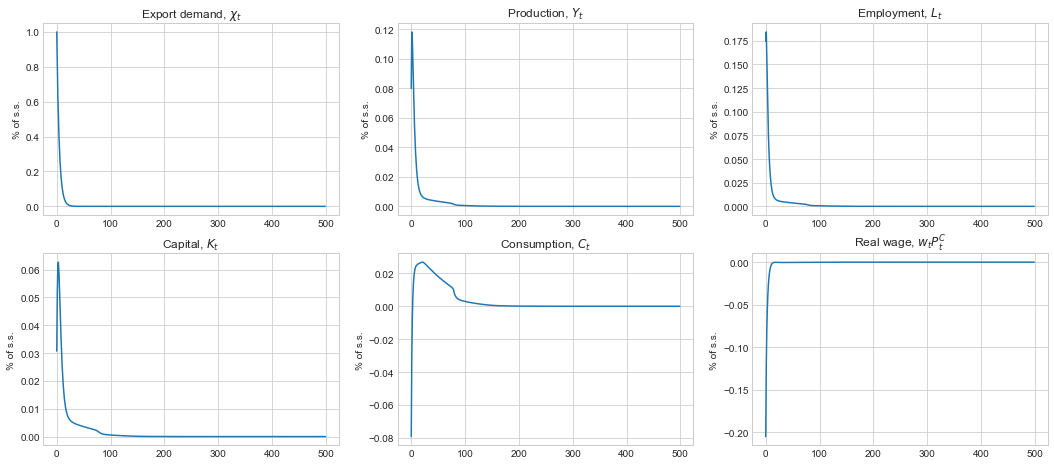

In [144]:
T_IRF = 500

fig = plt.figure(figsize=(3*6,3*6/1.5))

ax = fig.add_subplot(3,3,1)
ax.plot((sol.chi[:T_IRF]/ss.chi-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Export demand, $\chi_t$')

ax = fig.add_subplot(3,3,2)
ax.plot((sol.Y[:T_IRF]/ss.Y-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Production, $Y_t$')

ax = fig.add_subplot(3,3,3)
ax.plot((sol.L[:T_IRF]/ss.L-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Employment, $L_t$')

ax = fig.add_subplot(3,3,4)
ax.plot((sol.K[:T_IRF]/ss.K-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Capital, $K_t$')

ax = fig.add_subplot(3,3,5)
ax.plot((sol.C[:T_IRF]/ss.C-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Consumption, $C_t$')

ax = fig.add_subplot(3,3,6)
ax.plot(((sol.w[:T_IRF]/sol.P_C[:T_IRF])/(ss.w/ss.P_C)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Real wage, $w_tP^C_t$');